# AlexNet에서 Data Augmentation의 효과 분석

본 프로젝트는 CIFAR-10 이미지 분류 문제를 대상으로 AlexNet 모델을 구현하고, 데이터 증강 기법의 적용 여부에 따른 성능 차이를 실험적으로 비교 분석한 과제이다.

## 과제 목표

AlexNet 구조를 기반으로 기본 실험군과 데이터 증강을 적용한 실험군을 각각 학습시킨 후, 테스트 정확도와 일반화 성능을 비교하여 데이터 증강의 효과를 평가한다.

구현 내용 요약
- PyTorch 기반의 AlexNet 모델 구성
- CIFAR-10 데이터셋 로딩 및 전처리
- 기본 증강 및 추가 증강 기법 적용
- 동일한 모델과 하이퍼파라미터 하에 반복 실험 수행
- 실험 결과의 수치 비교 및 통계적 해석

## 사전 지식

### 1. AlexNet 구조

AlexNet은 2012년 ImageNet 대회에서 높은 성능을 기록하며 딥러닝 기반 이미지 분류 모델의 시대를 연 대표적인 합성곱 신경망이다. 주요 특징은 다음과 같다.
- 총 8개의 계층으로 구성 (5개의 Convolutional Layer, 3개의 Fully Connected Layer)
- ReLU 활성화 함수 사용
- Dropout 및 Local Response Normalization 기법 도입
- 병렬 연산을 위한 GPU 이중 분산 구조 설계


### 2. Data Augmentation

데이터 증강은 훈련 데이터에 다양한 변형을 적용함으로써, 모델이 더 일반화된 표현을 학습할 수 있도록 돕는 전처리 기법이다. 주로 이미지 분류 문제에서 적용되며, 특히 데이터의 양이 제한적일 때 효과적이다.

주요 증강 기법
- Random Crop: 이미지를 무작위로 잘라 학습
- Horizontal Flip: 좌우 반전 이미지 생성
- Color Jitter: 밝기, 명도, 채도 등의 변형 적용
- Rotation: 일정 각도 범위 내 회전


In [ ]:
# config

import torch

config = {
    "RANDOM_SEED": 42,
    "LEARNING_RATE": 1e-4,
    "BATCH_SIZE": 128,
    "NUM_EPOCHS": 90,
    "NUM_CLASSES": 10,
    "EARLY_STOP_PATIENCE": 10,
    "EARLY_STOP_MIN_DELTA": 0.001,
    "USE_AUGMENTATION": True,
    "SAVE_BEST_MODEL": True,
    "BEST_MODEL_PATH": "checkpoints/best_model.pth",
    "EXPERIMENT_NAME": "alexnet_cifar10_aug",
    "DEVICE": "cuda:0" if torch.cuda.is_available() else "cpu",
}

all_results = {}

## AlexNet 모델 정의

- features: 5개의 Convolution + ReLU + MaxPooling 계층 구성
- classifier: Flatten 후 3개의 Fully Connected Layer 구성
- CIFAR-10은 이미지 크기가 작기 때문에 (32x32), 마지막 Linear 입력 크기(256 * 4 * 4)를 조정함

In [ ]:
# model

import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

def get_dataloaders(use_augmentation=True, batch_size=128):
    if use_augmentation:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),          # 이미지의 일부를 무작위로 잘라내고 패딩 추가 (기존 유지)
            transforms.RandomHorizontalFlip(),             # 이미지를 무작위로 좌우 반전 (기존 유지)
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 밝기, 대비, 채도, 색조 무작위 변경
            # transforms.RandomRotation(15),                 # 이미지를 무작위로 최대 15도 회전
            # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # 이미지 무작위 이동 및 스케일 조정
            # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0), # 무작위로 사각형 영역 지우기
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


In [ ]:
# train

import torch
import time
import os
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_one_epoch(model, loader, optimizer, criterion, config):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(config["DEVICE"]), y.to(config["DEVICE"])
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += pred.argmax(1).eq(y).sum().item()
        total += y.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, config):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(config["DEVICE"]), y.to(config["DEVICE"])
            pred = model(x)
            loss = criterion(pred, y)
            running_loss += loss.item() * x.size(0)
            correct += pred.argmax(1).eq(y).sum().item()
            total += y.size(0)
    return running_loss / total, correct / total

def train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, config, exp_config):
    best_acc = 0
    epochs_no_improve = 0
    patience = config.get("EARLY_STOP_PATIENCE", 10)
    min_delta = config.get("EARLY_STOP_MIN_DELTA", 0.0)

    os.makedirs(os.path.dirname(config["BEST_MODEL_PATH"]), exist_ok=True)

    history = {
        "train_loss": [],
        "test_loss": [],
        "train_acc": [],
        "test_acc": [],
    }

    for epoch in range(config["NUM_EPOCHS"]):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, config)
        test_loss, test_acc = evaluate(model, test_loader, criterion, config)

        scheduler.step()

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

        final_acc = history["test_acc"][-1]
        all_results[exp_config.name] = final_acc

        improved = test_acc - best_acc > min_delta
        if improved:
            best_acc = test_acc
            epochs_no_improve = 0
            if config["SAVE_BEST_MODEL"]:
                torch.save(model.state_dict(), config["BEST_MODEL_PATH"])
        else:
            epochs_no_improve += 1

        print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f} (Best: {best_acc:.4f})")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. No improvement for {patience} epochs.")
            break

    plot_metrics(history, title=exp_config.name, save_path=f"plots/{exp_config.name}.png")
    return history

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, title=None, save_path=None):
    epochs = range(1, len(history['train_acc']) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['test_acc'], label='Test Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    if title:
        plt.title(f"{title} - Accuracy")

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['test_loss'], label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    if title:
        plt.title(f"{title} - Loss")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()

In [ ]:
import numpy as np

def summarize_results(all_results):
    baseline_accs = [acc for name, acc in all_results.items() if "baseline" in name]
    augmented_accs = [acc for name, acc in all_results.items() if "augmented" in name]

    def report(accs, label):
        print(f"\n{label} Accuracy Summary:")
        print(f"  Mean      : {np.mean(accs):.4f}")
        print(f"  Std Dev   : {np.std(accs):.4f}")
        print(f"  All Scores: {[f'{a:.4f}' for a in accs]}")

    report(baseline_accs, "Baseline")
    report(augmented_accs, "Augmented")

In [ ]:
class ExperimentConfig:
    def __init__(self, name, use_aug, seed, batch_size=128):
        self.name = name
        self.use_aug = use_aug
        self.seed = seed
        self.batch_size = batch_size
        self.model_path = f"checkpoints/best_model_{name}.pth"

def set_all_seeds(seed):
    import random, numpy as np
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def run_experiment(exp_config: ExperimentConfig):
    print(f"\n Running experiment: {exp_config.name} (Seed: {exp_config.seed})")
    set_all_seeds(exp_config.seed)
    os.makedirs("plots", exist_ok=True)

    train_loader, test_loader = get_dataloaders(exp_config.use_aug, exp_config.batch_size)
    model = AlexNet(num_classes=config["NUM_CLASSES"]).to(config["DEVICE"])
    optimizer = optim.Adam(model.parameters(), lr=config['LEARNING_RATE'])
    criterion = nn.CrossEntropyLoss()
    scheduler = CosineAnnealingLR(optimizer, T_max=config["NUM_EPOCHS"])

    train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, config, exp_config)


 Running experiment: baseline1 (Seed: 42)
[Epoch 1] Train Acc: 0.3736, Test Acc: 0.4906 (Best: 0.4906)
[Epoch 2] Train Acc: 0.5288, Test Acc: 0.5758 (Best: 0.5758)
[Epoch 3] Train Acc: 0.5950, Test Acc: 0.6190 (Best: 0.6190)
[Epoch 4] Train Acc: 0.6536, Test Acc: 0.6789 (Best: 0.6789)
[Epoch 5] Train Acc: 0.6946, Test Acc: 0.7079 (Best: 0.7079)
[Epoch 6] Train Acc: 0.7294, Test Acc: 0.7313 (Best: 0.7313)
[Epoch 7] Train Acc: 0.7574, Test Acc: 0.7525 (Best: 0.7525)
[Epoch 8] Train Acc: 0.7784, Test Acc: 0.7596 (Best: 0.7596)
[Epoch 9] Train Acc: 0.7987, Test Acc: 0.7629 (Best: 0.7629)
[Epoch 10] Train Acc: 0.8196, Test Acc: 0.7786 (Best: 0.7786)
[Epoch 11] Train Acc: 0.8352, Test Acc: 0.7847 (Best: 0.7847)
[Epoch 12] Train Acc: 0.8503, Test Acc: 0.7878 (Best: 0.7878)
[Epoch 13] Train Acc: 0.8654, Test Acc: 0.7956 (Best: 0.7956)
[Epoch 14] Train Acc: 0.8775, Test Acc: 0.7977 (Best: 0.7977)
[Epoch 15] Train Acc: 0.8924, Test Acc: 0.8051 (Best: 0.8051)
[Epoch 16] Train Acc: 0.9054, Test A

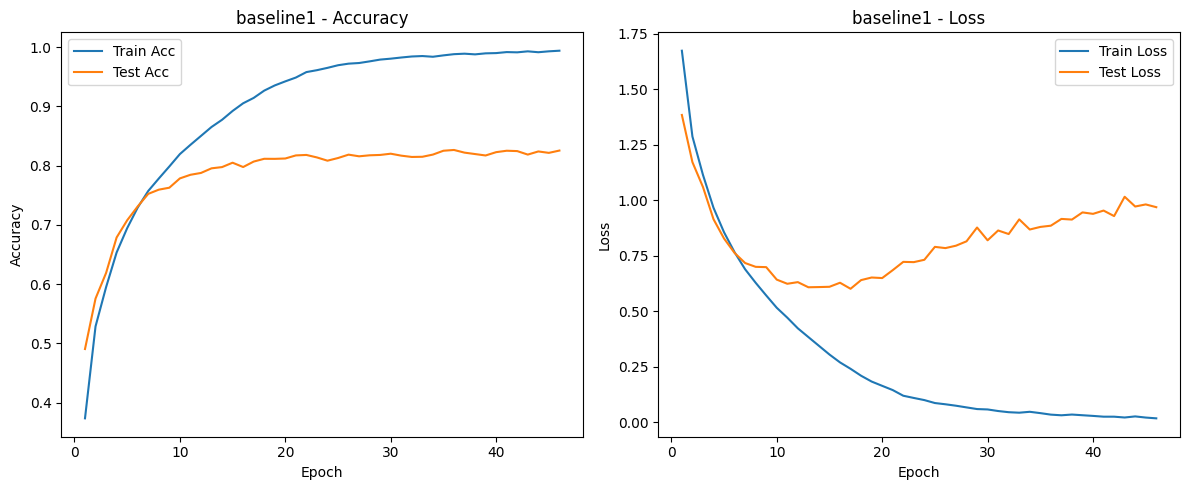


 Running experiment: augmented1 (Seed: 42)
[Epoch 1] Train Acc: 0.3258, Test Acc: 0.4384 (Best: 0.4384)
[Epoch 2] Train Acc: 0.4678, Test Acc: 0.5381 (Best: 0.5381)
[Epoch 3] Train Acc: 0.5342, Test Acc: 0.5860 (Best: 0.5860)
[Epoch 4] Train Acc: 0.5823, Test Acc: 0.6160 (Best: 0.6160)
[Epoch 5] Train Acc: 0.6204, Test Acc: 0.6559 (Best: 0.6559)
[Epoch 6] Train Acc: 0.6544, Test Acc: 0.6891 (Best: 0.6891)
[Epoch 7] Train Acc: 0.6816, Test Acc: 0.7024 (Best: 0.7024)
[Epoch 8] Train Acc: 0.7045, Test Acc: 0.7160 (Best: 0.7160)
[Epoch 9] Train Acc: 0.7237, Test Acc: 0.7403 (Best: 0.7403)
[Epoch 10] Train Acc: 0.7405, Test Acc: 0.7478 (Best: 0.7478)
[Epoch 11] Train Acc: 0.7549, Test Acc: 0.7584 (Best: 0.7584)
[Epoch 12] Train Acc: 0.7658, Test Acc: 0.7742 (Best: 0.7742)
[Epoch 13] Train Acc: 0.7794, Test Acc: 0.7745 (Best: 0.7742)
[Epoch 14] Train Acc: 0.7867, Test Acc: 0.7691 (Best: 0.7742)
[Epoch 15] Train Acc: 0.7978, Test Acc: 0.7975 (Best: 0.7975)
[Epoch 16] Train Acc: 0.8097, Test 

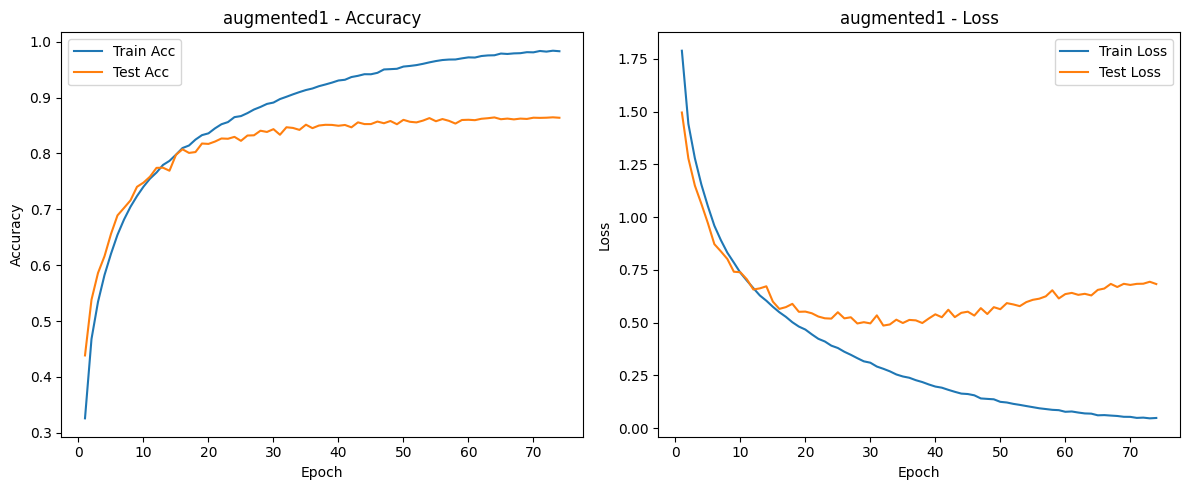


 Running experiment: baseline2 (Seed: 123)
[Epoch 1] Train Acc: 0.3672, Test Acc: 0.4885 (Best: 0.4885)
[Epoch 2] Train Acc: 0.5282, Test Acc: 0.5655 (Best: 0.5655)
[Epoch 3] Train Acc: 0.5969, Test Acc: 0.6372 (Best: 0.6372)
[Epoch 4] Train Acc: 0.6515, Test Acc: 0.6849 (Best: 0.6849)
[Epoch 5] Train Acc: 0.6958, Test Acc: 0.7091 (Best: 0.7091)
[Epoch 6] Train Acc: 0.7259, Test Acc: 0.7311 (Best: 0.7311)
[Epoch 7] Train Acc: 0.7537, Test Acc: 0.7477 (Best: 0.7477)
[Epoch 8] Train Acc: 0.7773, Test Acc: 0.7591 (Best: 0.7591)
[Epoch 9] Train Acc: 0.7976, Test Acc: 0.7760 (Best: 0.7760)
[Epoch 10] Train Acc: 0.8165, Test Acc: 0.7775 (Best: 0.7775)
[Epoch 11] Train Acc: 0.8332, Test Acc: 0.7832 (Best: 0.7832)
[Epoch 12] Train Acc: 0.8494, Test Acc: 0.7880 (Best: 0.7880)
[Epoch 13] Train Acc: 0.8626, Test Acc: 0.7937 (Best: 0.7937)
[Epoch 14] Train Acc: 0.8794, Test Acc: 0.7984 (Best: 0.7984)
[Epoch 15] Train Acc: 0.8915, Test Acc: 0.7926 (Best: 0.7984)
[Epoch 16] Train Acc: 0.9044, Test 

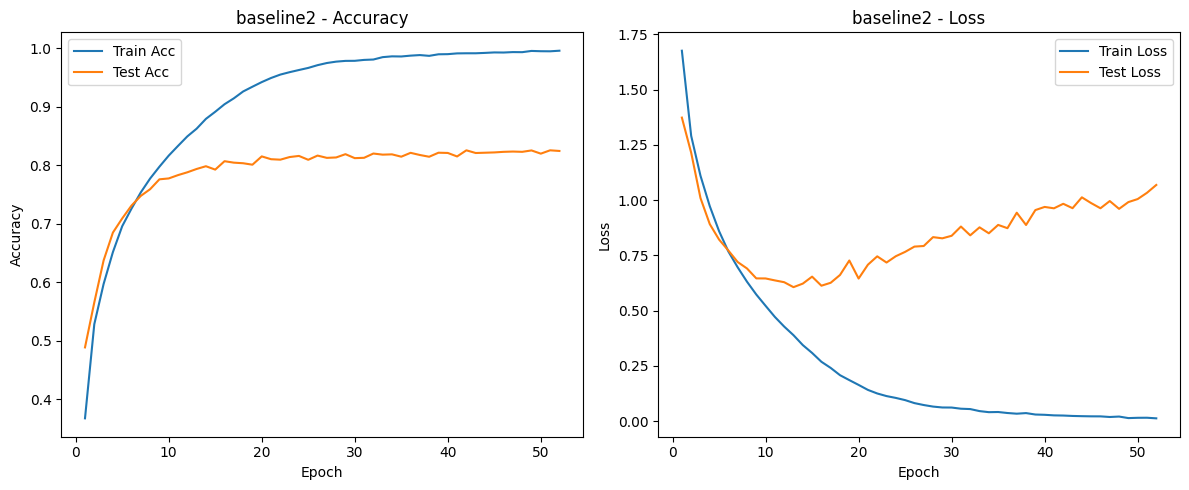


 Running experiment: augmented2 (Seed: 123)
[Epoch 1] Train Acc: 0.3224, Test Acc: 0.4462 (Best: 0.4462)
[Epoch 2] Train Acc: 0.4640, Test Acc: 0.5448 (Best: 0.5448)
[Epoch 3] Train Acc: 0.5351, Test Acc: 0.5725 (Best: 0.5725)
[Epoch 4] Train Acc: 0.5829, Test Acc: 0.6210 (Best: 0.6210)
[Epoch 5] Train Acc: 0.6203, Test Acc: 0.6470 (Best: 0.6470)
[Epoch 6] Train Acc: 0.6574, Test Acc: 0.6814 (Best: 0.6814)
[Epoch 7] Train Acc: 0.6789, Test Acc: 0.7160 (Best: 0.7160)
[Epoch 8] Train Acc: 0.7015, Test Acc: 0.7164 (Best: 0.7160)
[Epoch 9] Train Acc: 0.7233, Test Acc: 0.7447 (Best: 0.7447)
[Epoch 10] Train Acc: 0.7417, Test Acc: 0.7275 (Best: 0.7447)
[Epoch 11] Train Acc: 0.7518, Test Acc: 0.7493 (Best: 0.7493)
[Epoch 12] Train Acc: 0.7685, Test Acc: 0.7649 (Best: 0.7649)
[Epoch 13] Train Acc: 0.7764, Test Acc: 0.7733 (Best: 0.7733)
[Epoch 14] Train Acc: 0.7838, Test Acc: 0.7735 (Best: 0.7733)
[Epoch 15] Train Acc: 0.7979, Test Acc: 0.7996 (Best: 0.7996)
[Epoch 16] Train Acc: 0.8061, Test

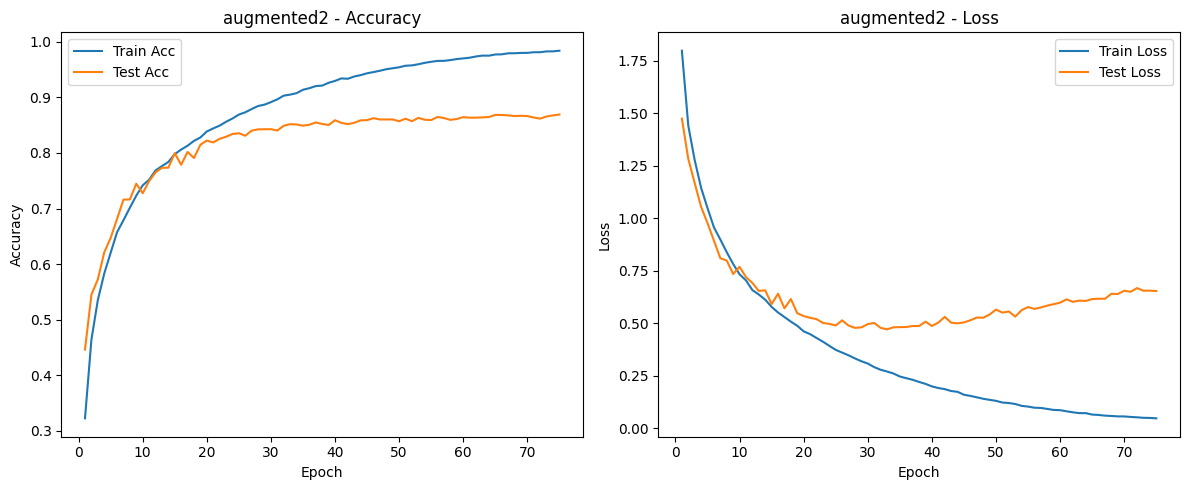


 Running experiment: baseline3 (Seed: 2024)
[Epoch 1] Train Acc: 0.3667, Test Acc: 0.4521 (Best: 0.4521)
[Epoch 2] Train Acc: 0.5196, Test Acc: 0.5714 (Best: 0.5714)
[Epoch 3] Train Acc: 0.5955, Test Acc: 0.6355 (Best: 0.6355)
[Epoch 4] Train Acc: 0.6472, Test Acc: 0.6734 (Best: 0.6734)
[Epoch 5] Train Acc: 0.6856, Test Acc: 0.7000 (Best: 0.7000)
[Epoch 6] Train Acc: 0.7200, Test Acc: 0.7285 (Best: 0.7285)
[Epoch 7] Train Acc: 0.7464, Test Acc: 0.7350 (Best: 0.7350)
[Epoch 8] Train Acc: 0.7706, Test Acc: 0.7631 (Best: 0.7631)
[Epoch 9] Train Acc: 0.7893, Test Acc: 0.7654 (Best: 0.7654)
[Epoch 10] Train Acc: 0.8085, Test Acc: 0.7758 (Best: 0.7758)
[Epoch 11] Train Acc: 0.8241, Test Acc: 0.7794 (Best: 0.7794)
[Epoch 12] Train Acc: 0.8394, Test Acc: 0.7853 (Best: 0.7853)
[Epoch 13] Train Acc: 0.8555, Test Acc: 0.7856 (Best: 0.7853)
[Epoch 14] Train Acc: 0.8711, Test Acc: 0.7950 (Best: 0.7950)
[Epoch 15] Train Acc: 0.8836, Test Acc: 0.8043 (Best: 0.8043)
[Epoch 16] Train Acc: 0.8950, Test

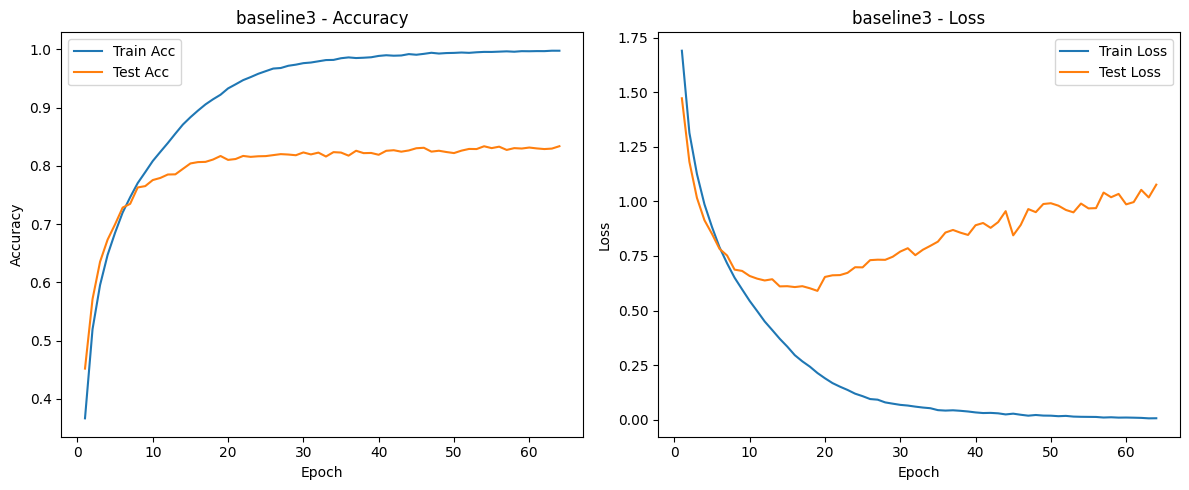


 Running experiment: augmented3 (Seed: 2024)
[Epoch 1] Train Acc: 0.3173, Test Acc: 0.3817 (Best: 0.3817)
[Epoch 2] Train Acc: 0.4663, Test Acc: 0.5344 (Best: 0.5344)
[Epoch 3] Train Acc: 0.5277, Test Acc: 0.5617 (Best: 0.5617)
[Epoch 4] Train Acc: 0.5798, Test Acc: 0.6338 (Best: 0.6338)
[Epoch 5] Train Acc: 0.6205, Test Acc: 0.6513 (Best: 0.6513)
[Epoch 6] Train Acc: 0.6584, Test Acc: 0.6866 (Best: 0.6866)
[Epoch 7] Train Acc: 0.6817, Test Acc: 0.7065 (Best: 0.7065)
[Epoch 8] Train Acc: 0.7035, Test Acc: 0.7199 (Best: 0.7199)
[Epoch 9] Train Acc: 0.7194, Test Acc: 0.7370 (Best: 0.7370)
[Epoch 10] Train Acc: 0.7418, Test Acc: 0.7429 (Best: 0.7429)
[Epoch 11] Train Acc: 0.7507, Test Acc: 0.7524 (Best: 0.7524)
[Epoch 12] Train Acc: 0.7633, Test Acc: 0.7613 (Best: 0.7613)
[Epoch 13] Train Acc: 0.7729, Test Acc: 0.7763 (Best: 0.7763)
[Epoch 14] Train Acc: 0.7876, Test Acc: 0.7883 (Best: 0.7883)
[Epoch 15] Train Acc: 0.7950, Test Acc: 0.7983 (Best: 0.7983)
[Epoch 16] Train Acc: 0.8016, Tes

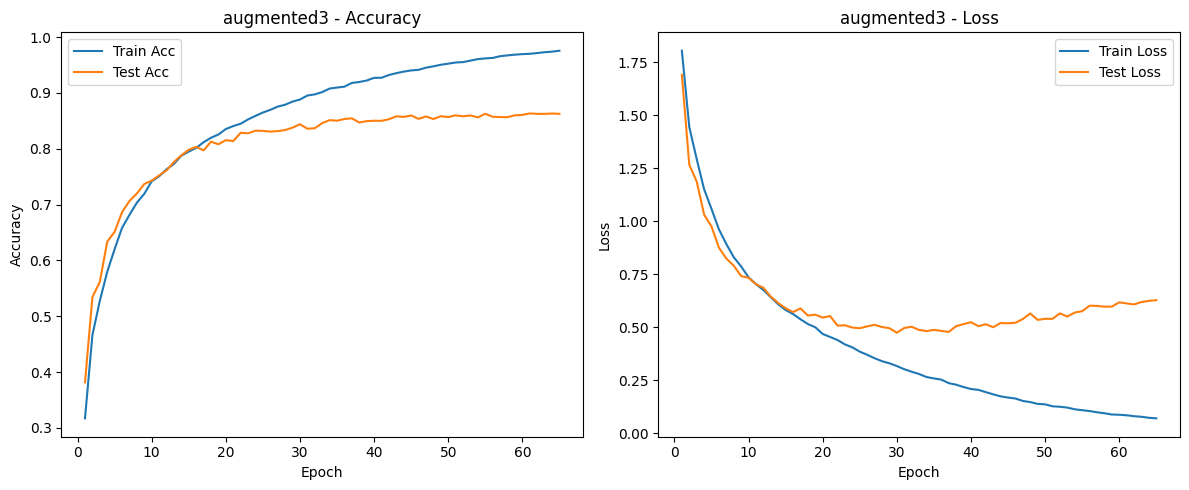


 Running experiment: baseline4 (Seed: 17)
[Epoch 1] Train Acc: 0.3587, Test Acc: 0.4798 (Best: 0.4798)
[Epoch 2] Train Acc: 0.5159, Test Acc: 0.5569 (Best: 0.5569)
[Epoch 3] Train Acc: 0.5908, Test Acc: 0.6189 (Best: 0.6189)
[Epoch 4] Train Acc: 0.6416, Test Acc: 0.6725 (Best: 0.6725)
[Epoch 5] Train Acc: 0.6832, Test Acc: 0.7019 (Best: 0.7019)
[Epoch 6] Train Acc: 0.7168, Test Acc: 0.7286 (Best: 0.7286)
[Epoch 7] Train Acc: 0.7483, Test Acc: 0.7168 (Best: 0.7286)
[Epoch 8] Train Acc: 0.7728, Test Acc: 0.7645 (Best: 0.7645)
[Epoch 9] Train Acc: 0.7935, Test Acc: 0.7682 (Best: 0.7682)
[Epoch 10] Train Acc: 0.8115, Test Acc: 0.7649 (Best: 0.7682)
[Epoch 11] Train Acc: 0.8279, Test Acc: 0.7848 (Best: 0.7848)
[Epoch 12] Train Acc: 0.8439, Test Acc: 0.7871 (Best: 0.7871)
[Epoch 13] Train Acc: 0.8606, Test Acc: 0.7976 (Best: 0.7976)
[Epoch 14] Train Acc: 0.8740, Test Acc: 0.7895 (Best: 0.7976)
[Epoch 15] Train Acc: 0.8882, Test Acc: 0.8023 (Best: 0.8023)
[Epoch 16] Train Acc: 0.8987, Test A

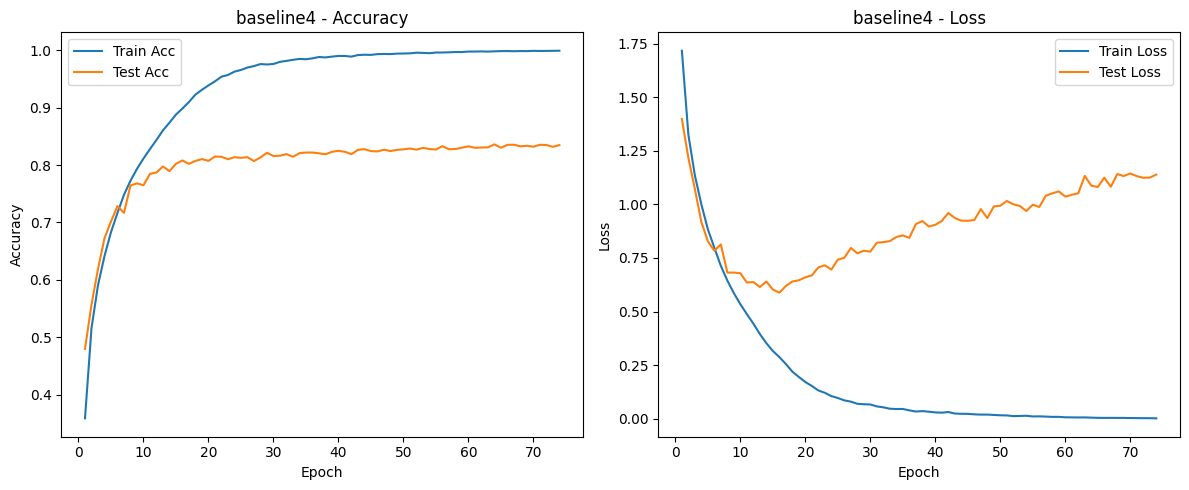


 Running experiment: augmented4 (Seed: 17)
[Epoch 1] Train Acc: 0.3142, Test Acc: 0.4299 (Best: 0.4299)
[Epoch 2] Train Acc: 0.4613, Test Acc: 0.5362 (Best: 0.5362)
[Epoch 3] Train Acc: 0.5332, Test Acc: 0.5874 (Best: 0.5874)
[Epoch 4] Train Acc: 0.5779, Test Acc: 0.5967 (Best: 0.5967)
[Epoch 5] Train Acc: 0.6139, Test Acc: 0.6668 (Best: 0.6668)
[Epoch 6] Train Acc: 0.6514, Test Acc: 0.6806 (Best: 0.6806)
[Epoch 7] Train Acc: 0.6792, Test Acc: 0.7077 (Best: 0.7077)
[Epoch 8] Train Acc: 0.7011, Test Acc: 0.7271 (Best: 0.7271)
[Epoch 9] Train Acc: 0.7233, Test Acc: 0.7350 (Best: 0.7350)
[Epoch 10] Train Acc: 0.7352, Test Acc: 0.7436 (Best: 0.7436)
[Epoch 11] Train Acc: 0.7545, Test Acc: 0.7537 (Best: 0.7537)
[Epoch 12] Train Acc: 0.7641, Test Acc: 0.7607 (Best: 0.7607)
[Epoch 13] Train Acc: 0.7772, Test Acc: 0.7853 (Best: 0.7853)
[Epoch 14] Train Acc: 0.7875, Test Acc: 0.7764 (Best: 0.7853)
[Epoch 15] Train Acc: 0.8003, Test Acc: 0.7939 (Best: 0.7939)
[Epoch 16] Train Acc: 0.8082, Test 

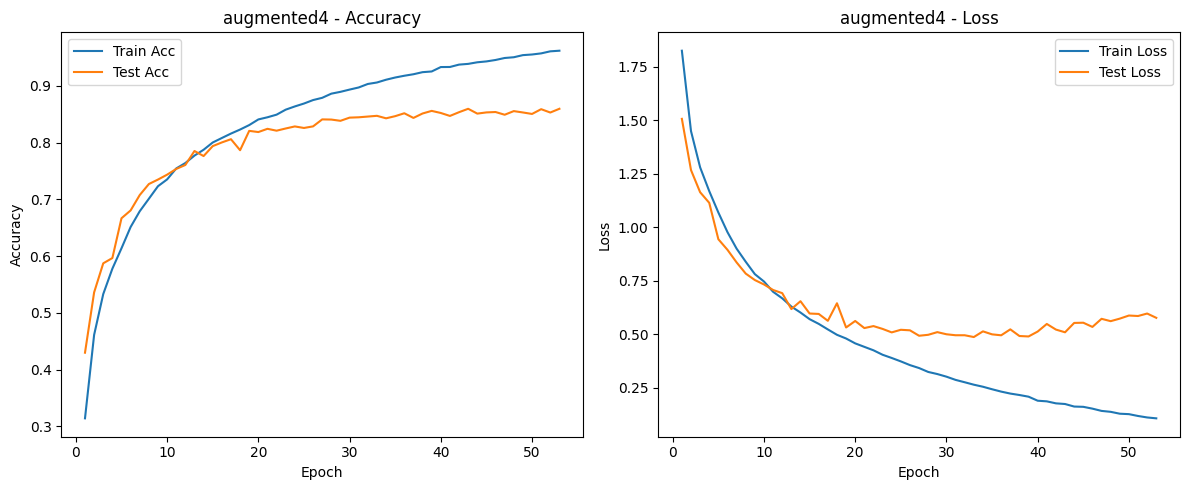


 Running experiment: baseline5 (Seed: 777)
[Epoch 1] Train Acc: 0.3594, Test Acc: 0.4694 (Best: 0.4694)
[Epoch 2] Train Acc: 0.5127, Test Acc: 0.5756 (Best: 0.5756)
[Epoch 3] Train Acc: 0.5901, Test Acc: 0.6290 (Best: 0.6290)
[Epoch 4] Train Acc: 0.6420, Test Acc: 0.6754 (Best: 0.6754)
[Epoch 5] Train Acc: 0.6870, Test Acc: 0.6878 (Best: 0.6878)
[Epoch 6] Train Acc: 0.7148, Test Acc: 0.7201 (Best: 0.7201)
[Epoch 7] Train Acc: 0.7474, Test Acc: 0.7411 (Best: 0.7411)
[Epoch 8] Train Acc: 0.7687, Test Acc: 0.7558 (Best: 0.7558)
[Epoch 9] Train Acc: 0.7915, Test Acc: 0.7679 (Best: 0.7679)
[Epoch 10] Train Acc: 0.8077, Test Acc: 0.7739 (Best: 0.7739)
[Epoch 11] Train Acc: 0.8259, Test Acc: 0.7823 (Best: 0.7823)
[Epoch 12] Train Acc: 0.8403, Test Acc: 0.7919 (Best: 0.7919)
[Epoch 13] Train Acc: 0.8558, Test Acc: 0.7922 (Best: 0.7919)
[Epoch 14] Train Acc: 0.8725, Test Acc: 0.7978 (Best: 0.7978)
[Epoch 15] Train Acc: 0.8838, Test Acc: 0.8070 (Best: 0.8070)
[Epoch 16] Train Acc: 0.8947, Test 

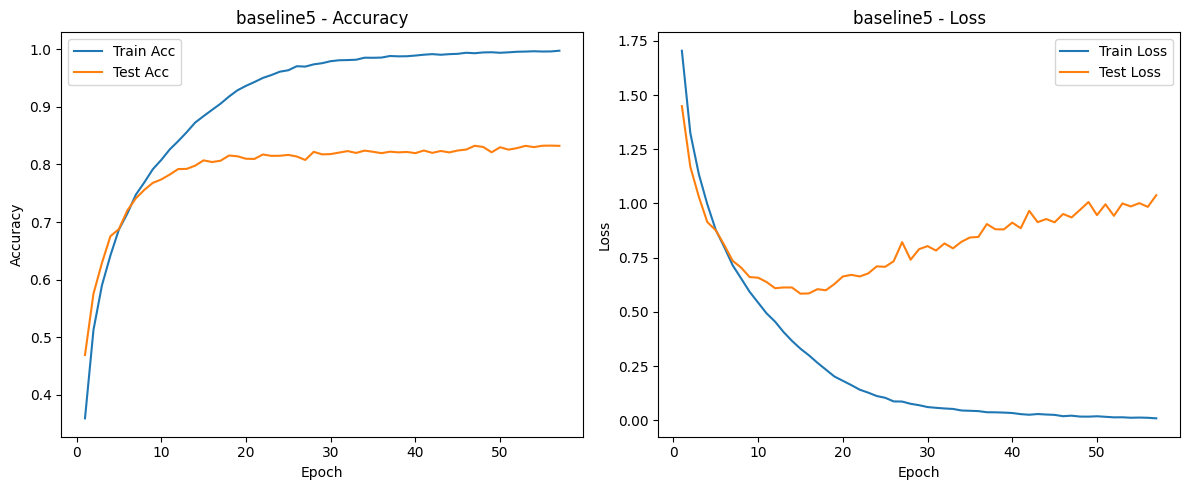


 Running experiment: augmented5 (Seed: 777)
[Epoch 1] Train Acc: 0.3167, Test Acc: 0.4196 (Best: 0.4196)
[Epoch 2] Train Acc: 0.4579, Test Acc: 0.5164 (Best: 0.5164)
[Epoch 3] Train Acc: 0.5256, Test Acc: 0.5916 (Best: 0.5916)
[Epoch 4] Train Acc: 0.5791, Test Acc: 0.6313 (Best: 0.6313)
[Epoch 5] Train Acc: 0.6209, Test Acc: 0.6507 (Best: 0.6507)
[Epoch 6] Train Acc: 0.6534, Test Acc: 0.6902 (Best: 0.6902)
[Epoch 7] Train Acc: 0.6807, Test Acc: 0.7128 (Best: 0.7128)
[Epoch 8] Train Acc: 0.7034, Test Acc: 0.7249 (Best: 0.7249)
[Epoch 9] Train Acc: 0.7230, Test Acc: 0.7434 (Best: 0.7434)
[Epoch 10] Train Acc: 0.7377, Test Acc: 0.7546 (Best: 0.7546)
[Epoch 11] Train Acc: 0.7530, Test Acc: 0.7599 (Best: 0.7599)
[Epoch 12] Train Acc: 0.7642, Test Acc: 0.7562 (Best: 0.7599)
[Epoch 13] Train Acc: 0.7754, Test Acc: 0.7748 (Best: 0.7748)
[Epoch 14] Train Acc: 0.7875, Test Acc: 0.7834 (Best: 0.7834)
[Epoch 15] Train Acc: 0.7966, Test Acc: 0.7947 (Best: 0.7947)
[Epoch 16] Train Acc: 0.8048, Test

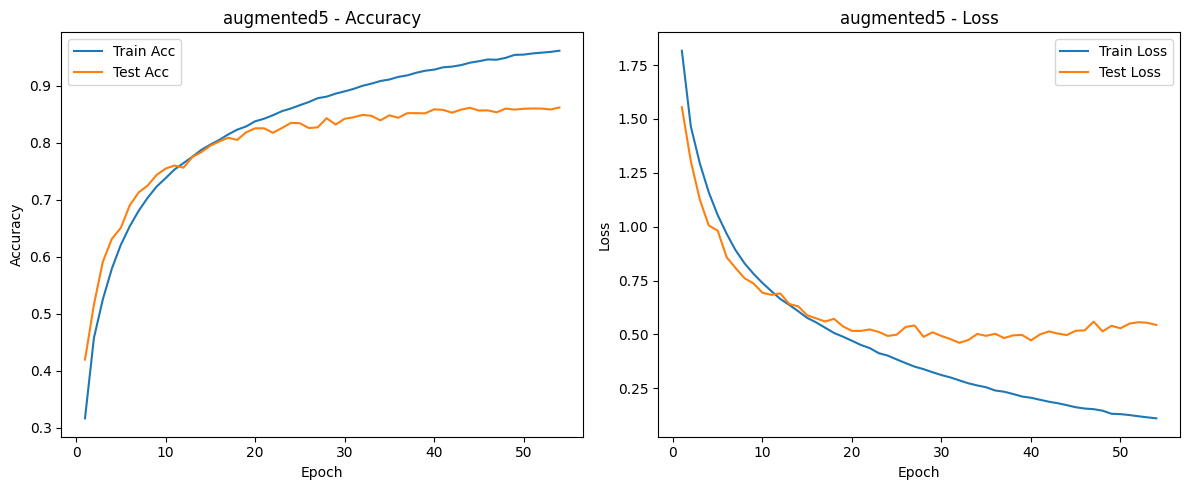


Baseline Accuracy Summary:
  Mean      : 0.8302
  Std Dev   : 0.0043
  All Scores: ['0.8256', '0.8245', '0.8339', '0.8348', '0.8322']

Augmented Accuracy Summary:
  Mean      : 0.8634
  Std Dev   : 0.0032
  All Scores: ['0.8639', '0.8692', '0.8626', '0.8597', '0.8617']


In [ ]:
# main
import torch
import torch.nn as nn
import torch.optim as optim
import os

def main():
    seeds = [42, 123, 2024, 17, 777]  # 실험 5회

    experiments = []
    for i, seed in enumerate(seeds, 1):
        experiments.append(ExperimentConfig(name=f"baseline{i}", use_aug=False, seed=seed))
        experiments.append(ExperimentConfig(name=f"augmented{i}", use_aug=True, seed=seed))

    for exp in experiments:
        run_experiment(exp)

    summarize_results(all_results)

if __name__ == "__main__":
    main()

## 실험 결과

| **실험 조건** | **실험 1** | **실험 2** | **실험 3** | **실험 4** | **실험 5** | **평균 정확도** |
| --- | --- | --- | --- | --- | --- | --- |
| baseline | 0.8256 | 0.8245 | 0.8339 | 0.8348 | 0.8322 | 0.8291 |
| with_data_augmentation | 0.8639 | 0.8692 | 0.8626 | 0.8597 | 0.8617 | 0.8634 |
| add_augmentation | 0.8587 | 0.8720 | 0.8726 | 0.8701 | 0.8706 | 0.8688 |



## 실험 설계 및 결과 해석

본 실험은 동일한 AlexNet 모델과 학습 설정 하에, 랜덤 시드(seed)만 다르게 설정하여 총 5회씩 실험을 반복 수행하였다. 이렇게 시드를 다르게 설정한 이유는 딥러닝 실험의 결과가 가중치 초기화, 데이터 셔플링 등에 따라 영향을 받을 수 있기 때문이다. 이를 통해 각 실험 조건의 평균 성능과 분산을 보다 신뢰도 있게 평가할 수 있다.

1. baseline

데이터 증강 없이 수행된 실험으로, 평균 정확도는 약 82.9%로 측정되었다. 실험 간 성능 편차는 약 ±0.5% 수준으로 비교적 안정적인 수렴 경향을 보였다.

2. with_data_augmentation

기본적인 수평 뒤집기 및 랜덤 크롭을 포함한 데이터 증강을 적용한 조건으로, 평균 정확도는 약 86.3%로 baseline 대비 약 3.4%p 향상되었다. 또한, 실험 간 결과의 일관성도 높았으며, 이는 증강된 데이터가 일반화 성능에 긍정적인 영향을 미쳤음을 보여준다.

3. add_augmentation

기본 증강 외에 추가적으로 Color Jitter, Rotation, RandomAffine 등의 기법이 포함된 조건으로, 평균 정확도는 약 86.9%로 가장 높았다. 단일 실험에서도 모두 87% 근처의 성능을 보였으며, variance가 가장 작았다.

## 종합 평가

모든 조건에서 시드에 따라 일부 편차는 있었지만, 데이터 증강을 적용한 조건에서 평균 성능이 명확하게 우수하였다. 특히, add_augmentation 조건은 더욱 다양한 시각적 변형을 학습 데이터에 포함시켜, 모델의 일반화 능력을 최대화한 것으로 해석할 수 있다.
